### 🖼️ 🔤 Visual–Text Mis‑alignment Detection

This tool spots news items whose **image does not match the headline or body text**.

| What it does | Details |
|--------------|---------|
| **Inputs**   | Main image · headline · lead/body paragraph (8 EU languages) |
| **Outputs**  | `aligned` or `misaligned` + confidence (0–1) |
| **Model**    | Dual‑encoder (CLIP‑style) fine‑tuned on mis‑alignment pairs |
| **Goal**     | Surface misleading thumbnails, recycled photos, or click‑bait imagery |

**Notebook flow**

1. Batch‑send each article’s image + text to the API  
2. Collect predictions
3. Aggregate daily *Aligned vs Misaligned* counts  
4. Save `aligned_vs_misaligned_daily.json`  
5. Plot a stacked bar chart to visualise trends


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║  Multimodal Visual‑Text Mis‑alignment (MVTMD) – Full Analytics Notebook  ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# ▸ Works from a fresh session – only needs TRINO_HOST, TRINO_USER, TRINO_CATALOG env‑vars

# ──────────────────────────────────────────────────────────────────────────
# 1 ▸ Install runtime dependencies (comment‑out after first run)
# ──────────────────────────────────────────────────────────────────────────
%pip install -q trino==0.332.0 trino[sqlalchemy] pandas matplotlib scikit-learn numpy


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# ──────────────────────────────────────────────────────────────────────────
# 2 ▸ Imports, Utilities & Plot Style
# ──────────────────────────────────────────────────────────────────────────
import os, re, warnings, json, datetime as dt
from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors


In [ ]:

from sklearn.metrics import precision_recall_curve, average_precision_score
from trino.dbapi import connect

# JSON helper functions (from Code 2)
def _json_default(value):
    """JSON serializer for date/time objects (returns ISO format)."""
    if isinstance(value, (dt.datetime, dt.date)):
        return value.isoformat()
    return repr(value)

def save_dict(d: dict, path: Path):
    """Save a dictionary to a file in JSON format."""
    path.write_text(json.dumps(d, default=_json_default))

def load_dict(path: Path) -> dict:
    """Load a dictionary from a JSON file."""
    return json.loads(path.read_text())

# Host/port parser (from Code 2)
def _parse_host_port(host: Optional[str], port: Optional[str], default_port: int = 8080) -> Tuple[str, int]:
    """Parse combined host and port information from environment variables."""
    host = (host or "").strip()
    port = (port or "").strip()
    # Remove protocol prefixes like http:// or tcp://
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)
    # If host string contains "host:port" and port is not given separately
    if ":" in host and not port:
        host, port = host.split(":", 1)
    # Extract port number or use default
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    # Ensure port is in valid range; otherwise use default
    if not (1 <= port_int <= 65_535):
        port_int = default_port
    return host or "localhost", port_int

# Configure warnings and plot style
warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.style.use("default")


In [ ]:

# ──────────────────────────────────────────────────────────────────────────
# 3 ▸ USER INPUTS – adjust freely
# ──────────────────────────────────────────────────────────────────────────
START_DATE   = "2025-04-25"
END_DATE     = "2025-06-29"
LIMIT        = None           # None = no limit on query results
TOP_N_LANG   = 12
THRESHOLD    = 0.5
ROLLING_DAYS = 7


In [ ]:

# ──────────────────────────────────────────────────────────────────────────
# 4 ▸ Connect to Trino & fetch data
# ──────────────────────────────────────────────────────────────────────────
# Prepare Trino connection parameters using environment variables (with defaults)
TRINO_HOST, TRINO_PORT = _parse_host_port(os.getenv("TRINO_HOST"), os.getenv("TRINO_PORT"))
TRINO_USER    = os.getenv("TRINO_USER", "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")

print(f"🔌 Connecting to Trino at {TRINO_HOST}:{TRINO_PORT}, catalog='{TRINO_CATALOG}' (user={TRINO_USER})")
conn = connect(host=TRINO_HOST, port=TRINO_PORT, user=TRINO_USER, catalog=TRINO_CATALOG)
cur  = conn.cursor()

# Define and execute SQL query
sql = """
SELECT
    cn.id,
    cn.language,
    cn.publish_date,
    mvtmd.score,
    mvtmd.prediction
FROM   news.collected_news AS cn
JOIN   tools.multimodal_visual_text_misalignment_detection AS mvtmd
       ON cn.id = mvtmd.content_id
"""
if LIMIT:
    sql += f"\nLIMIT {LIMIT}"
print("Executing query …")
cur.execute(sql)
df = pd.DataFrame(cur.fetchall(), columns=[c[0] for c in cur.description])
cur.close(); conn.close()
print(f"✅ Fetched {len(df):,} rows.")


🔌 Connecting to Trino at trino:8080, catalog='iceberg' (user=trino)
Executing query …
✅ Fetched 3,521 rows.


In [ ]:

# ──────────────────────────────────────────────────────────────────────────
# 5 ▸ Cleansing & optional date filter
# ──────────────────────────────────────────────────────────────────────────
df['language']     = df['language'].fillna('unknown')
df['prediction']   = df['prediction'].astype(int)
df['score']        = pd.to_numeric(df['score'], errors='coerce')
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce', utc=True)
df                 = df.dropna(subset=['score', 'publish_date'])

if START_DATE and END_DATE:
    mask = df['publish_date'].between(pd.to_datetime(START_DATE, utc=True),
                                      pd.to_datetime(END_DATE,   utc=True))
    df = df[mask]
    print(f"After date filter: {len(df):,} rows remain.")


After date filter: 2,314 rows remain.


In [ ]:

# ──────────────────────────────────────────────────────────────────────────
# 6 ▸ TIME‑SERIES VISUALISATIONS
# ──────────────────────────────────────────────────────────────────────────
ts_df = df.set_index('publish_date').sort_index()

# 6‑B. Diverging daily counts of predictions (0 = aligned, 1 = misaligned)
# --------------------------------------------------------------------------
daily_counts = (
    ts_df.groupby([pd.Grouper(freq='D'), 'prediction'])
         .size()
         .unstack(fill_value=0)
         .sort_index()
)
# Ensure both prediction columns (0 and 1) exist, fill missing with 0
daily_counts = daily_counts.reindex(columns=[0, 1], fill_value=0)


In [ ]:

# Save daily diverging bar chart data & metadata to JSON (as in Code 2)
daily_counts.index.name = "publish_date"  # name the index for clarity
daily_counts_df = daily_counts.reset_index().rename(columns={0: "aligned", 1: "misaligned"})
plot_data = daily_counts_df.to_dict(orient="list")  # convert data to column-wise dict
color_map = {
    "aligned":   mcolors.to_hex("seagreen"),   # color for aligned (0)
    "misaligned": mcolors.to_hex("indianred")  # color for misaligned (1)
}
plot_meta = {
    "data"      : plot_data,
    "title"     : "Daily aligned vs mis‑aligned volume",
    "chart_type": "diverging_bar",
    "platform"  : "News",
    "color_map" : color_map
}
json_path = Path("aligned_vs_misaligned_daily.json")
save_dict(plot_meta, json_path)
print(f"💾 Saved JSON → {json_path.resolve()}")


💾 Saved JSON → /home/kadkhoda/aligned_vs_misaligned_daily.json


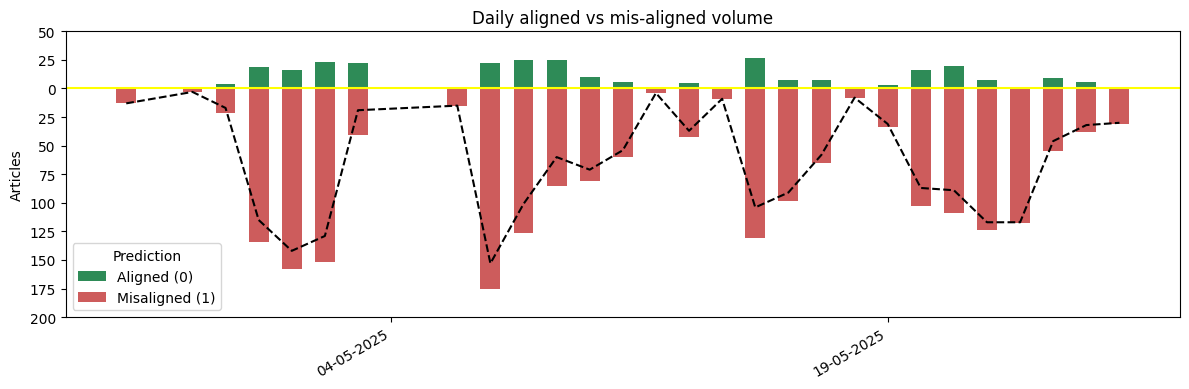

In [ ]:

# Load the JSON and reproduce the plot
meta = load_dict(json_path)
# Reconstruct DataFrame from saved data
df_loaded = pd.DataFrame(meta["data"])
# Parse dates back to datetime objects and set as DataFrame index
df_loaded["publish_date"] = pd.to_datetime(df_loaded["publish_date"], utc=True)
df_loaded = df_loaded.set_index("publish_date").sort_index()

# Prepare to plot using reloaded data
fig, ax = plt.subplots(figsize=(12, 4))
bar_width = 0.6  # narrower bars (width less than 1 day)
# Plot aligned counts above x-axis and misaligned counts below (negative)
ax.bar(df_loaded.index, df_loaded["aligned"], width=bar_width,
       color=meta["color_map"]["aligned"], label="Aligned (0)")
ax.bar(df_loaded.index, -df_loaded["misaligned"], width=bar_width,
       color=meta["color_map"]["misaligned"], label="Misaligned (1)")

# Plot the difference line and a horizontal baseline at 0
diff = df_loaded["aligned"] - df_loaded["misaligned"]
ax.plot(df_loaded.index, diff, c="k", ls="--")
ax.axhline(0, color="yellow")

# Title, labels, and legend (using metadata title)
ax.set_title(meta["title"])
ax.set_ylabel("Articles")
locator   = mdates.DayLocator(interval=15)
formatter = mdates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
fig.autofmt_xdate()  # rotate date labels for readability

# Use absolute values for y-axis tick labels (so misaligned shows as positive number)
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels([int(abs(t)) for t in yticks])

ax.legend(title="Prediction")
plt.tight_layout()
plt.show()


